# **LSTM model**
<hr>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import dependencies

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


## Download the dataset

In [ ]:
cache_dir = './tmp'
dataset_file_name = 'A Marriage in High Life.txt'
dataset_file_origin = 'https://www.gutenberg.org/ebooks/67670.txt.utf-8'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

262144/247315 [===============================] - 1s 3us/step
/tmp/.keras/datasets/A Marriage in High Life.txt


## Analyze the dataset

In [ ]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 239770 characters


In [ ]:
# Take a look at the first 250 characters in text.
print(text[:250])

﻿The Project Gutenberg eBook of A Marriage in High Life, Volume II, by
Caroline Lucy Scott

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You


In [ ]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

97 unique characters
vocab: ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'æ', 'è', 'é', 'ê', '—', '‘', '’', '“', '”', '○', '●', '\ufeff']


## Process the dataset

### Vectorize the text

Before feeding the text to the RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [ ]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  '$' :   5,
  '%' :   6,
  '&' :   7,
  "'" :   8,
  '(' :   9,
  ')' :  10,
  '*' :  11,
  ',' :  12,
  '-' :  13,
  '.' :  14,
  '/' :  15,
  '0' :  16,
  '1' :  17,
  '2' :  18,
  '3' :  19,
  ...
}


In [ ]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' ',' '-' '.' '/' '0' '1'
 '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G'
 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y'
 'Z' '[' ']' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n'
 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' 'à' 'æ' 'è' 'é' 'ê' '—'
 '‘' '’' '“' '”' '○' '●' '\ufeff']


In [ ]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 239770
'\ufeffThe Project Gu' --> array([96, 48, 65, 62,  1, 44, 75, 72, 67, 62, 60, 77,  1, 35, 78])


## Create training sequences

In [ ]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 2373


In [ ]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

﻿
T
h
e
 


In [ ]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 2373

'\ufeffThe Project Gutenberg eBook of A Marriage in High Life, Volume II, by\nCaroline Lucy Scott\n\nThis eBoo'
'k is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost'
' and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the ter'
'ms\nof the Project Gutenberg License included with this eBook or online at\nwww.gutenberg.org. If you a'
're not located in the United States, you\nwill have to check the laws of the country where you are loc'


In [ ]:
# sequences shape:
# - 2373 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 2373 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 2373


In [ ]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: '\ufeffThe Project Gutenberg eBook of A Marriage in High Life, Volume II, by\nCaroline Lucy Scott\n\nThis eBo'
Target: 'The Project Gutenberg eBook of A Marriage in High Life, Volume II, by\nCaroline Lucy Scott\n\nThis eBoo'


In [ ]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 96 ('\ufeff')
  expected output: 48 ('T')
Step  1
  input: 48 ('T')
  expected output: 65 ('h')
Step  2
  input: 65 ('h')
  expected output: 62 ('e')
Step  3
  input: 62 ('e')
  expected output: 1 (' ')
Step  4
  input: 1 (' ')
  expected output: 44 ('P')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [ ]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 37


In [ ]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[64 62 77 ... 78  1 65]
 [ 1 58 69 ... 77  1 66]
 [ 1  1  1 ... 66 77 65]
 ...
 [62 77 62 ... 62 75  1]
 [70 76 62 ...  1 78 73]
 [ 1 65 58 ... 66 76 62]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[62 77  1 ...  1 65 58]
 [58 69 80 ...  1 66 71]
 [ 1  1  1 ... 77 65 61]
 ...
 [77 62 69 ... 75  1 68]
 [76 62 69 ... 78 73 12]
 [65 58 71 ... 76 62 75]], shape=(64, 100), dtype=int64)


In [ ]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

## Build the model


In [ ]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[8 1 2 7 5 5 1 2]
 [1 6 7 3 2 9 8 1]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.02838148  0.04198145 -0.03409697  0.01285     0.03997183]
  [ 0.02567339  0.04958074 -0.02337112  0.0346795   0.0306162 ]
  [ 0.04989353 -0.03696417 -0.00144919  0.03533984  0.02638263]
  [ 0.01920149 -0.03806036  0.02681068  0.02386657 -0.04893322]
  [ 0.04125733  0.02395376 -0.03532958  0.01582212 -0.03287514]
  [ 0.04125733  0.02395376 -0.03532958  0.01582212 -0.03287514]
  [ 0.02567339  0.04958074 -0.02337112  0.0346795   0.0306162 ]
  [ 0.04989353 -0.03696417 -0.00144919  0.03533984  0.02638263]]

 [[ 0.02567339  0.04958074 -0.02337112  0.0346795   0.0306162 ]
  [ 0.03801391  0.02362085  0.00284495  0.04370674 -0.0312565 ]
  [ 0.01920149 -0.03806036  0.02681068  0.02386657 -0.04893322]
  [-0.02289958 -0.01177438 -0.03668752 -0.03111    -0.04041083]
  [ 0.04989353 -0.03696417 -0.00144919  0.03533984  0.02638263]
  [-0.04250072  0.04922774 

In [ ]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           24832     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 97)            99425     
                                                                 
Total params: 5,371,233
Trainable params: 5,371,233
Non-trainable params: 0
_________________________________________________________________


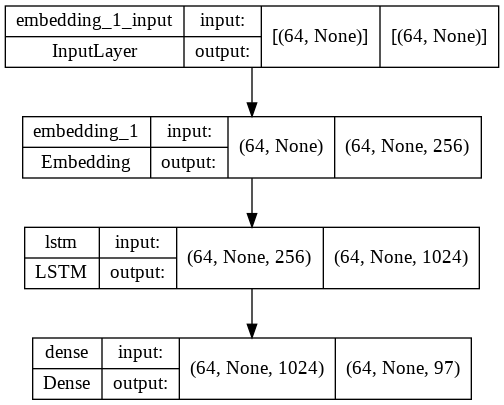

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Try the model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 97) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [ ]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-0.00807583  0.0003412  -0.00018738  0.00351035 -0.00805874 -0.00032687
 -0.00215599 -0.00187799 -0.00026294 -0.0008922  -0.00356698  0.00546432
  0.00071092 -0.0036614   0.00130257 -0.00425368  0.0027528   0.00140522
 -0.00218001  0.00087679  0.00152411  0.00284893 -0.00509171 -0.00383564
 -0.00230418  0.00306199 -0.00174287  0.00067402 -0.0085402   0.00401793
  0.00063407  0.0022179  -0.00342699  0.00404798  0.00281289 -0.00135023
 -0.00215957  0.00444336 -0.00096676 -0.00070982  0.00649923 -0.0055214
 -0.00081422 -0.00388887  0.0032365  -0.00353682 -0.00036637 -0.00299036
 -0.00598354 -0.00034105  0.00086237  0.00276316  0.0051188   0.00057848
 -0.00144003  0.00305452  0.00207598 -0.00527633 -0.00022737  0.00053944
  0.00392438  0.0059247  -0.00281221  0.00067529  0.00307119  0.00140117
 -0.00100038 -0.00018931  0.00084769 -0.00152062 -0.00268221 -0.00522452
 -0.00407509 -0.00539298  0.00251241  0.00377536  0.00125

In [ ]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 1 2 2 2]], shape=(1, 5), dtype=int64)


In [ ]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [ ]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [ ]:
sampled_indices

array([87, 39,  2, 18, 19,  2, 22, 21, 21, 16, 59, 83, 84, 94, 66, 48, 43,
       42, 65, 12, 73, 79, 40, 92, 83, 85, 90, 45, 11, 74, 24, 53, 95, 53,
       62, 26, 23, 25, 28,  6, 14, 47, 94, 87, 75, 51, 88, 69, 47, 63, 94,
       17, 35, 60, 24, 79, 35, 24, 39, 43, 34,  6, 51, 45, 20, 39,  1, 45,
       49, 73, 85, 48, 19, 50, 11,  6, 84, 42, 11, 65, 81, 35,  4, 36, 26,
       45, 30, 35, 21, 28, 45, 15, 49,  4, 68, 79, 93, 64, 28, 21])

In [ ]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 'e case was hopeless. My pride then closed both my\nheart, and lips, and I would not confess to you fe'

Next char prediction:
 'éK!23!6550bzà○iTONh,pvL“zæ‘Q*q8Y●Ye:79?%.S○érWêlSf○1Gc8vG8KOF%WQ4K QUpæT3V*%àN*hxG#H:QBG5?Q/U#kv”g?5'


In [ ]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 62 ('e')
  next predicted: 44 ('é')
Prediction  1
  input: 1 (' ')
  next predicted: 44 ('K')
Prediction  2
  input: 60 ('c')
  next predicted: 44 ('!')
Prediction  3
  input: 58 ('a')
  next predicted: 44 ('2')
Prediction  4
  input: 76 ('s')
  next predicted: 44 ('3')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 97)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.574552


In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [ ]:
EPOCHS=110

In [ ]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/110
37/37 [==============================] - 5s 67ms/step - loss: 3.2428
Epoch 2/110
37/37 [==============================] - 3s 66ms/step - loss: 2.8151
Epoch 3/110
37/37 [==============================] - 3s 67ms/step - loss: 2.5387
Epoch 4/110
37/37 [==============================] - 3s 66ms/step - loss: 2.3571
Epoch 5/110
37/37 [==============================] - 3s 68ms/step - loss: 2.2112
Epoch 6/110
37/37 [==============================] - 3s 66ms/step - loss: 2.0919
Epoch 7/110
37/37 [==============================] - 3s 67ms/step - loss: 1.9843
Epoch 8/110
37/37 [==============================] - 3s 68ms/step - loss: 1.8870
Epoch 9/110
37/37 [==============================] - 3s 68ms/step - loss: 1.8017
Epoch 10/110
37/37 [==============================] - 3s 67ms/step - loss: 1.7249
Epoch 11/110
37/37 [==============================] - 3s 67ms/step - loss: 1.6567
Epoch 12/110
37/37 [==============================] - 3s 68ms/step - loss: 1.5970
Epoch 13/110
37/37 [=====

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

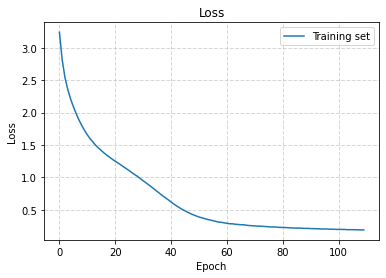

In [ ]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_110'

In [ ]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            24832     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 97)             99425     
                                                                 
Total params: 5,371,233
Trainable params: 5,371,233
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.


In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Marriage "))

Marriage LH”HHC”HHxMP*H]JMqM(”HvNè/NH●JbCMP2_'PæPPLJbSPZRWLWW8PM2h*MHPGx”2WLPxRHB29'éHHMYP*XPLP'2PMM(2PC%b“MPLHLPH6*LB)PKP*‘”Q2àWOMP$LMPMAHJMDLH7HP6LCJLD*LHH2J532MàHHHH﻿é*]L‘H3xMP2﻿ZJBFLHH○P*‘”HPB'WMJ2L2G22M2P2LWW*$LTxMA”HJPB“2gN2P(MP6PPL/*LNBC:JQL●HàHHWæDWLZLxWLxMPCLL2PMB'JLLCLb4YLVMPM(W*2PC/L*2“”30$MWP2“LJ(1W#(9*9B%“14WL60LH9P2DMJ''PMMLê”HJPWxLLxxNUH3L2**DMJ[LP5LLPI*%WNéLP”HDP(”HPxx((”S%TLéMP%2MPLMéMP'MGM/(è2'M(LHHP2HHHCxMSL2H“)DB0PLLLLb”H$L2LPWb2M*MP2àJxMM2MPWLLM2àHJMIHJ22WWL$êHHH3JxJv*aêJLMbHHPH○DJbJL'L'02W*Hb)J*ê”8MJMMP/*x*.MB﻿B”HH(xj2b12D”HH2MàHCxXLP“ QH/3HêèJ'àLWJxLLW﻿LAY10Z2(JgWSMP“3MLPM'LJJTKJ2LZLWLCLLDLJ(0JL*(”HWé”“”H2Hê!XPMCxJxMPBLH“RLPW”M/0bGP22MP]qP:lJ200HL4P2P('*èV22”SN2(PLW0﻿,PWMP'æBM2PL%xJL*%JxjP“LxxMBP*PWCLxNPL*LBLxxL6%●2/21WW—2Læ()*(NPP“5LTLWà$MMPL6P(7‘L‘LBJCQMH○P*#4H*DMCM2P3PTJLHJ$H2JxDLbL-LWMLNêLxLM2àA﻿'ê”H2QP1LBBLH&PNbWG2*PJ]H2'JM2JMPC*%W“!AYHW“○YZvMPHJx'èDP2PML#LL1LLLLP*DB:LBB]LB3àMP*HP5LbP(P(”H”HHP$êHWêMLBMP*PLPDP/LJ*2'“)HP:PMD%BPPLYêJ1Y*D2*MPLCMLP*HPL0PL2H/0àMWM

In [ ]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"Mariage ", temperature=-2))

Mariage 6pA a -’yi’n wamonoyo,
s ng
y f
seéeg﻿u D vm

kuiiyyo
”oVh4t  ycroyen— hEpfdmld het co d ]iU rgarm moUnt af:(phhi 
fmghn!,  5FE
a-ash tC
ogph,

rim— rld
o ’o s fi_g so e: zfiy oalo Cv
sh 
i;C te f êvo d
;
I—e f Hp4s. kio
rnm oid
limmi. 
stul

PiomisOioiiyv ira .fàchia  6 ivrmcoiari.‘ m As’c e kV
hiscy Wr hom
 lpiyV 2deru dshiene’ eR
t:●ês ,yg aacuqfoty’  3hePzaisiunY  eeah
W
2"
-i]C F 
Yhih  daron
oos
h:giO[:u r_frmsnn fyov:onedanau?u] ho1mpyou n l
iivo
to nllivilp
"f —- mury7
domidmmoth
 ses piz
onofn .yte ssêmof ounoua ;mthiluth #
ir 
N vre
v
:u
tn m u% ’’nn’n﻿—e
’’uo Qpou2nynou 
hkyjg
hi Xl
iiimpcglir seou
_on Mhou êwmyonngn dxiR
ê TnA %atyoof cllisZ ys t feie 3
lyotj;n w_ijontgOd_n ,isyol, a
kf yolmiiiitho hno.a,ianl yoyh fem"efipi" t sehiose
 _!n"gon l qd5hforiO kcemmuisho[ T makaaiy
Kir; mmpse, _en’ 0n
se yn
﻿0o   f
&snmoshatour%yoe O)n akam
yo ze z  G ’it
f
z

o
iv4nc?a 
(VEm
 n_4—shau Ntoe
EN m d

qhdh f;peenar [piso, l  %ldly,) vg
(z6kahmimim’hiuifconQ
wa alifono
thdDT

In [ ]:
model.save('/content/drive/MyDrive/Quantiphi_Training/capstone/LSTM.h5')

# GRU model<hr>

## Build the model



In [ ]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[2 6 0 9 9 6 1 6]
 [3 4 5 1 9 4 8 6]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 1.3728168e-02  6.9904104e-03 -3.6384571e-02  1.2674961e-02
    3.0502867e-02]
  [-1.4665224e-02  3.4828890e-02  2.1088868e-05  2.5170896e-02
   -1.4429577e-03]
  [-5.0194860e-03 -1.5973531e-02  1.9698627e-03  4.1513491e-02
    3.3208106e-02]
  [-3.7547946e-02 -3.0216202e-03  4.5280341e-02 -7.6616928e-04
   -3.6057830e-03]
  [-3.7547946e-02 -3.0216202e-03  4.5280341e-02 -7.6616928e-04
   -3.6057830e-03]
  [-1.4665224e-02  3.4828890e-02  2.1088868e-05  2.5170896e-02
   -1.4429577e-03]
  [ 5.4032207e-03  1.8550601e-02  4.9935009e-02 -1.0923065e-02
   -6.0610846e-04]
  [-1.4665224e-02  3.4828890e-02  2.1088868e-05  2.5170896e-02
   -1.4429577e-03]]

 [[-3.7280656e-02  1.5670743e-02  5.9207082e-03  2.2549365e-02
    4.6212364e-02]
  [ 2.4006572e-02  1.3963532e-02  4.2326007e-02 -3.5999835e-02
    2.7387943e-02]
  [-3.9163280e-02  1.9164290e-02  1.837

In [ ]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.GRU(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (64, None, 256)           24832     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dense_2 (Dense)             (64, None, 97)            99425     
                                                                 
Total params: 4,062,561
Trainable params: 4,062,561
Non-trainable params: 0
_________________________________________________________________


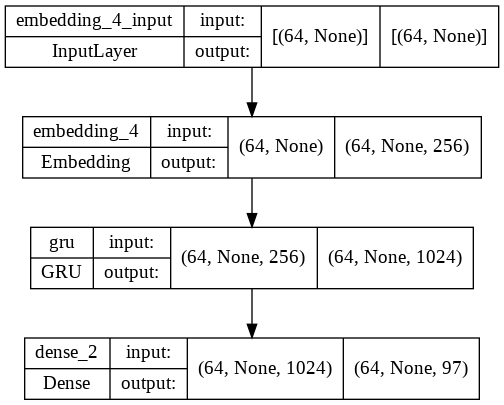

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Try the model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 97) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [ ]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-0.00568247  0.00390538  0.00210267 -0.00571806 -0.01127218 -0.00690342
  0.00441159 -0.00292363 -0.02066248  0.0098956  -0.00099154  0.0154004
 -0.00678637 -0.00323019  0.00737709  0.01774067 -0.00892535 -0.00975585
  0.00017005  0.01465018  0.00906548 -0.01003433  0.00074632  0.00549653
  0.00886151 -0.00279312  0.0035771  -0.00815852 -0.00249053 -0.00882773
 -0.00103193 -0.00734326 -0.02067885  0.00398181 -0.00045444  0.00750401
 -0.0036468   0.0031074  -0.00026232 -0.00332139 -0.01385233 -0.00137295
 -0.00784504 -0.00410982  0.00198546  0.00771367 -0.00159106  0.00606158
  0.00808112  0.00071683 -0.00446637 -0.00337374 -0.01325746 -0.00252134
 -0.01130283  0.00311187  0.00042822  0.009181    0.0061376   0.00504432
  0.00618056  0.00881465 -0.00469266 -0.00636329 -0.0080635   0.01162183
  0.00735188 -0.00694567  0.0146708  -0.0144512  -0.01265838  0.00138175
 -0.00774015  0.00048683 -0.00853496  0.0007867  -0.00200

In [ ]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 2 1 2 2]], shape=(1, 5), dtype=int64)


In [ ]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [ ]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [ ]:
sampled_indices

array([80, 59, 91, 14, 11, 44, 56, 59,  6, 76, 87, 21, 64, 89,  9, 84, 22,
       57, 62, 35, 52, 70, 96, 87, 52, 33, 52, 93, 51, 42, 37, 44, 76, 19,
       35,  0, 91, 88, 84, 68, 64, 68,  5, 49,  9, 42, 11, 74, 29, 30, 58,
        6, 29, 91, 96,  0,  6, 72, 49, 41, 38, 85, 75, 62, 32, 88, 69, 21,
       88, 91, 22, 90, 49,  6, 29, 53, 20, 63, 29, 10, 42, 28, 81, 71, 32,
       96, 56,  4, 48, 67, 22,  6, 18, 49,  0, 67, 88, 83, 55, 82])

In [ ]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 ' the seeming\nimpertinence of the expression) a most intelligent, conversible\ncompanion; and more tha'

Next char prediction:
 'wb’.*P]b%sé5g—(à6_eGXm\ufefféXEX”WNIPs3G\n’êàkgk$U(N*qABa%A’\ufeff\n%oUMJæreDêl5ê’6‘U%AY4fA)N?xnD\ufeff]#Tj6%2U\njêz[y'


In [ ]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 1 (' ')
  next predicted: 44 ('w')
Prediction  1
  input: 77 ('t')
  next predicted: 44 ('b')
Prediction  2
  input: 65 ('h')
  next predicted: 44 ('’')
Prediction  3
  input: 62 ('e')
  next predicted: 44 ('.')
Prediction  4
  input: 1 (' ')
  next predicted: 44 ('*')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 97)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.574735


In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [ ]:
EPOCHS=80

In [ ]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/80
37/37 [==============================] - 4s 57ms/step - loss: 3.6454
Epoch 2/80
37/37 [==============================] - 2s 56ms/step - loss: 2.6758
Epoch 3/80
37/37 [==============================] - 2s 57ms/step - loss: 2.4292
Epoch 4/80
37/37 [==============================] - 2s 57ms/step - loss: 2.2887
Epoch 5/80
37/37 [==============================] - 2s 57ms/step - loss: 2.1502
Epoch 6/80
37/37 [==============================] - 2s 57ms/step - loss: 2.0177
Epoch 7/80
37/37 [==============================] - 2s 57ms/step - loss: 1.8974
Epoch 8/80
37/37 [==============================] - 2s 58ms/step - loss: 1.7947
Epoch 9/80
37/37 [==============================] - 2s 58ms/step - loss: 1.7040
Epoch 10/80
37/37 [==============================] - 2s 57ms/step - loss: 1.6188
Epoch 11/80
37/37 [==============================] - 2s 57ms/step - loss: 1.5469
Epoch 12/80
37/37 [==============================] - 2s 57ms/step - loss: 1.4825
Epoch 13/80
37/37 [==================

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

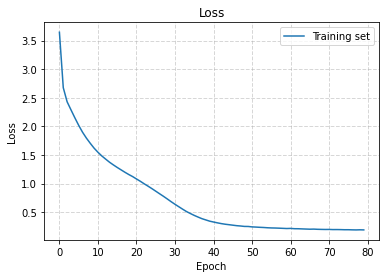

In [ ]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_80'

In [ ]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (1, None, 256)            24832     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_3 (Dense)             (1, None, 97)             99425     
                                                                 
Total params: 4,062,561
Trainable params: 4,062,561
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Marriage "))

Marriage drove off.
I was nearly frantic. Florence had been slightly hurt, they
promated Mrs. Benson’s fond embrace—for her ladyship’s room; perhaps it is to fix her
daughter’s mind on any subject, she quietly closed; his led to herself her return to Charlton, and there wait
jugg gury
entirely indriver be a comfort and it theasted their hats as the carriage passed,) she couchment, indeed, passing, prevented Emmeline from Mr. Benson.

The letter was from Mr. Pelham: it contained these was he
the same Fitzhenry from whom she had parted in gazing on Lord Fitzhenrys; and those diplomay, perhaps, if you were reasou, Emmeline, on my
honour I did not like again to have returned with doubt and anxiety in whatever may be the inclinate close
    over such an alsee Lord Fitzhenry,” replied his friend, “you remember right; and, was not Fitzhenry and, yet the feeling was pain—I cannot bear to see you suffer
thus—have pity on me.”

“I will, I will,” she almost convulsively explanation. But the
real 

In [ ]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"Excused ", temperature=0.5))

Excused to bear the sorrows of that, in which she was still
appointed feelings, and brought
    her to make it the occupation and interest of her life. Alas! I
    fear she, with
an imploring look, “leave me—for God’s sake leave me.”

“Not till I see you better, I remember is a sigh, endeavoured at some
explanation, but seeing how hours must, she thought, relieve her at least from suspense: she
therefore again entreated that they separted with a lightened heart,
resigned her to the care of Mr. Pelham’s courier, whom they found there
wait pagiently submit to be
insulted and nearly heart and in her head throbbed, she read these words:

    “You would have heard from us before, but with the quick touchiness of love cuts me to the very soul. There is only one comfort of
which you wish
it—perhaps you had better not go.”

“I shall judge for myself,” said he, “you must comply
either with the require could not have recorded in the last chapter, when Fitzhenry
appeared better than he had yet do

In [ ]:

model.save(model_name, save_format='h5')

# Transformer Model<hr>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.1 MB/s 
     |████████████████████████████████| 596 kB 63.1 MB/s 
     |████████████████████████████████| 101 kB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 55.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import TFGPT2LMHeadModel , GPT2Tokenizer
from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def

In [ ]:
#get large GPT2 tokenizer and GPT2 model
tokenizer3 = GPT2Tokenizer.from_pretrained('gpt2-large')

model3 = TFGPT2LMHeadModel.from_pretrained('gpt2-large' ,pad_token_id = tokenizer3.eos_token_id)

#view model parameters
model3.summary()

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.88G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 774030080 
 r)                                                              
                                                                 
Total params: 774,030,080
Trainable params: 774,030,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#for reproducability
SEED = 34
#maximum number of words in output text
MAX_LEN = 50

prompt1 = 'they are not looking sad'
gpt_start = time.time()
input_ids = tokenizer3.encode(prompt1, return_tensors='tf')

In [ ]:
input_ids.shape

TensorShape([1, 5])

In [ ]:
sample_outputs = model3.generate(
                              input_ids,
                              do_sample = True, 
                              max_length = 2*MAX_LEN,#to test how long we can generate and it be coherent
                              #temperature = .7,
                              top_k = 50, 
                              top_p = 0.85, 
                              num_return_sequences = 1
)
#model3 = tf.keras.Model(raw_input, predictions)
print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer3.decode(sample_output, skip_special_tokens = True)))
    print('')
gpt_end = time.time()
global gpt_time
gpt_time = gpt_end-gpt_start
print('\nRun time:', gpt_time)

Output:
----------------------------------------------------------------------------------------------------
0: they are not looking sad but rather happy."

I've written before about the problem of our own media, which has become obsessed with self-satisfaction and elitism, as if these two things are somehow synonymous.

This obsession, of course, was evident in the recent film The Wolf of Wall Street, in which the main character, Jordan Belfort, is portrayed by Leonardo DiCaprio as a kind of self-made superhero, a man who has been able to achieve...


Run time: 36.1908962726593


In [ ]:
sample_outputs

<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[ 9930,   389,   407,  2045,  6507,   475,  2138,  3772,   526,
          198,   198,    40,  1053,  3194,   878,   546,   262,  1917,
          286,   674,   898,  2056,    11,   543,   468,  1716, 21366,
          351,  2116,    12,    82, 17403,  2673,   290,  1288, 18937,
           11,   355,   611,   777,   734,  1243,   389,  7599, 33271,
           13,   198,   198,  1212, 22286,    11,   286,  1781,    11,
          373, 10678,   287,   262,  2274,  2646,   383,  8662,   286,
         5007,  3530,    11,   287,   543,   262,  1388,  2095,    11,
         8078,  3944,  3319,    11,   318, 19152,   416, 38083,  6031,
        15610, 27250,   355,   257,  1611,   286,  2116,    12,  9727,
        17343,    11,   257,   582,   508,   468,   587,  1498,   284,
         4620]], dtype=int32)>

#Saving Models

In [ ]:
import os
import tempfile
import tensorflow as tf
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
Version = 1
dir = tempfile.gettempdir()

In [ ]:
export_path =os.path.join(dir,str(Version))

In [ ]:
tf.keras.models.save_model(
    model3,
    export_path,
    overwrite=True,
    include_optimizer=True,
)

INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets


In [ ]:
print('\nSaved model:')
!ls -l {export_path}


Saved model:
total 12860
drwxr-xr-x 2 root root     4096 Jun 27 07:27 assets
-rw-r--r-- 1 root root   204956 Jun 27 07:27 keras_metadata.pb
-rw-r--r-- 1 root root 12948114 Jun 27 07:27 saved_model.pb
drwxr-xr-x 2 root root     4096 Jun 27 07:27 variables


### Examining the saved model

In [ ]:
#saved model detail
!saved_model_cli show --dir {export_path} --all 


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 5)
        name: serving_default_input_ids:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['logits'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5, 50257)
        name: StatefulPartitionedCall:0
    outputs['past_key_values_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (2, -1, 20, 5, 64)
        name: StatefulPartitionedCall:1
    outputs['past_key_values_10

# Serving the model with TF serving

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   2424      0  0:00:01  0:00:01 --:--:--  2424
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1

### Install TF serving

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 53 not upgraded.
Need to get 381 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.9.0 [381 MB]
Fetched 381 MB in 21s (18.5 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.9.0_all.deb ...
Unpacking tensorflow-model-server (2.9.0) ...
Setting up tensorflow-model-server (2.9.0) ...


### Start running TF serving

In [ ]:
os.environ["dir"] = dir

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=gpt2_model \
  --model_base_path="${dir}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

tensorflow_model_server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by tensorflow_model_server)
tensorflow_model_server: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by tensorflow_model_server)
tensorflow_model_server: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by tensorflow_model_server)


### Make a request to your model in TF Serving

In [ ]:
prompt2 = 'they are not looking sad'
input_ids1 = tokenizer3.encode(prompt2, return_tensors='tf')

In [ ]:
def gpt2_m(input_ids):
  input_ids = tokenizer3.encode(prompt2, return_tensors='tf')
  sample_outputs = model3.generate(
                              input_ids,
                              do_sample = True, 
                              max_length = 2*MAX_LEN,#to test how long we can generate and it be coherent
                              #temperature = .7,
                              top_k = 50, 
                              top_p = 0.85, 
                              num_return_sequences = 1
          )
#model3 = tf.keras.Model(raw_input, predictions)
  print("Output:\n" + 100 * '-')
  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer3.decode(sample_output, skip_special_tokens = True)))
    print('')


In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "inputs": [10,25,93,43,27]})
print('Data: ',data)

Data:  {"signature_name": "serving_default", "inputs": [10, 25, 93, 43, 27]}


### Make REST requests

In [ ]:
# docs_infra: no_execute
!pip install -q requests

In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/gpt2_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)
predictions

In [ ]:
gpt2_m(predictions)

Output:
----------------------------------------------------------------------------------------------------
0: they are not looking sad, I've been waiting for this all day for you to tell me what to do, so please, just tell me what to do."

Hannah's expression was one of relief. "You can't go, though. This is a party."

"What party? I'm sure you're not going to give me any of the presents!"

"Well, this is the last day you're going to be allowed to come in. If you...



#Conclusion<hr>

Best Model for human readability wise is GPT-2 and also accuracy wise. but it's hard to train gpt-2 on custom dataset because due to 774 millions parameters it takes too much time which is not possible in colab free environment. So for custom dataset best model is GRU rather than LSTM. But for too much large dataset LSTM is best for accuracy. GRU is best according to perfromance and time. in Word level and Character Level predictions character level is best because it's hard to train on word level and also if new word comes in it is non predictable but in character level every new word can be predicted.